In [6]:

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))
from core.viz import plot_line, create_subplot_grid, plot_bar
from core.s3 import S3AssetManager



from core.utils import ensure_dirs
from core.utils import read_excel_from_s3

In [2]:
notebook_name = "okuo_primer_ensayo_acidez_h2o"
s3 = S3AssetManager(notebook_name=notebook_name)
PALETTE =  [ "#1c8074","#1a494c", "#94af92", "#666666", "#f9ee77", "#f5ad68", "#c76931"]

In [3]:

raw = s3.read_excel(
    "raw/ensayos_acidez/evalucacion acidificantes.xlsx",
    sheet_name='datos revisados',
    skiprows=11
)
df = raw[['producto', 'ph', 'tiempo', 'orp']]
df.loc[:, "tiempo"] = pd.to_datetime(df["tiempo"])

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_52109/2349118700.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "tiempo"] = pd.to_datetime(df["tiempo"])
/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_52109/2349118700.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "tiempo"] = pd.to_datetime(df["tiempo"])


In [4]:
df.head()

,producto,ph,tiempo,orp
0,Citroquim Aqua,6.81,2025-01-01 12:05:00,666
1,selko ph,6.61,2025-01-01 12:25:00,677
2,Clap,6.66,2025-01-01 12:40:00,666
3,Pka,6.71,2025-01-01 13:42:00,656
4,Acido citrico,6.34,2025-01-01 14:14:00,670


In [7]:
def add_elapsed_hours(df: pd.DataFrame) -> pd.DataFrame:
    """Añade columna 'elapsed_h' por producto."""
    first = df.groupby("producto")["tiempo"].min()
    df["elapsed_h"] = df.apply(
        lambda r: (r["tiempo"] - first[r["producto"]]).total_seconds() / 3600,
        axis=1,
    )
    return df

def filter_post_dose(df: pd.DataFrame) -> pd.DataFrame:
    """Quita la lectura inicial si pH > 6."""
    mask = ~((df["elapsed_h"] == 0) & (df["ph"] > 6))
    return df.loc[mask].copy()

def stability_table(df: pd.DataFrame) -> pd.DataFrame:
    """Devuelve CV, SD y rango de pH por producto."""
    stab = (
        df.groupby("producto")
          .agg(
              n   = ("ph",  "count"),
              # ---- pH ----
              pH_mean   = ("ph",  "median"),
              pH_sd     = ("ph",  "std"),
              pH_range  = ("ph",  lambda x: x.max() - x.min()),
              pH_cv_pct = ("ph",  lambda x: x.std() / x.mean() * 100),

              # ---- ORP ----
              ORP_mean   = ("orp", "median"),
              ORP_sd     = ("orp", "std"),
              ORP_range  = ("orp", lambda x: x.max() - x.min()),
              ORP_cv_pct = ("orp", lambda x: x.std() / x.mean() * 100),
          )
          .round(3)
          .sort_values("pH_sd")        # ordena por menor variabilidad de pH
    )
    return stab


# ------------------------------------------------------------------
# 1) Curva temporal (pH, ORP, etc.)
# ------------------------------------------------------------------
def plot_metric_curve(
    df: pd.DataFrame,
    metric: str,
    x: str = "elapsed_h",
    color_col: str = "producto",
    palette: list[str] = PALETTE,
    title: str | None = None,
    yaxis_title: str | None = None,
    save_html: str | Path | None = None,
    annotate_initial: bool = True,
) -> go.Figure:

    # Mapa producto → color
    prods      = df[color_col].unique()
    color_map  = {p: palette[i % len(palette)] for i, p in enumerate(prods)}

    # Línea principal
    fig = px.line(
        df, x=x, y=metric, color=color_col,
        color_discrete_map=color_map, markers=True,
        title=title or f"Evolución de {metric.upper()}",
    )
    fig.update_layout(
    title=dict(font=dict(color="black"), x=0.5)  # x=0.5 lo centra
    )

    # Ejes y estética en negro
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        paper_bgcolor="rgba(0,0,0,0)",
        legend_title="",
        legend_font_color="black",
        xaxis=dict(
            title="Horas transcurridas",
            title_font_color="black",
            tickfont_color="black",
            linecolor="black",
            mirror=True, showline=True,             # marco
            gridcolor="rgba(0,0,0,0.1)",
        ),
        yaxis=dict(
            title=yaxis_title or metric.upper(),
            title_font_color="black",
            tickfont_color="black",
            linecolor="black",
            mirror=True, showline=True,
            gridcolor="rgba(0,0,0,0.1)",
        ),
    )

    # Marco negro (shape) – opcional, realza el borde
    fig.add_shape(type="rect",
                  xref="paper", yref="paper",
                  x0=0, y0=0, x1=1, y1=1,
                  line=dict(color="black", width=1))

    # Flecha en t=0
    if annotate_initial:
        ini_vals = df[df[x] == 0][metric]
        if not ini_vals.empty:
            fig.add_annotation(
                x=0, y=ini_vals.max(),
                text="condición inicial",
                showarrow=True, arrowhead=3,
                arrowwidth=1.5, arrowcolor="#C9C9C9",
                ax=40, ay=-40,
                font=dict(color="#666666"),
                #bgcolor="rgba(0,0,0,0)",
                bordercolor="#666666",
            )

    if save_html:
        save_path = Path(save_html)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.write_html(save_path, include_plotlyjs="cdn")
        print(f"[INFO] Curva guardada en {save_path.resolve()}")

    return fig

# ------------------------------------------------------------------
# 2) Barra de estabilidad (SD pH) con CV %
# ------------------------------------------------------------------
def plot_ph_stability_bar(
    stab: pd.DataFrame,
    palette: list[str] = PALETTE,
    save_html: str | Path | None = None,
) -> go.Figure:

    stab = stab.copy()
    stab["producto"] = stab.index
    stab = stab.sort_values("pH_sd")  # ordenar de más estable a menos

    fig = px.bar(
        stab,
        x="producto", y="pH_sd",
        color="producto",
        color_discrete_sequence=palette * 3,
        #text=stab["pH_cv_pct"].map(lambda v: f"{v:.2f}%"),
        title="Estabilidad del pH con los productos",
    )
    fig.update_layout(
    title=dict(font=dict(color="black"), x=0.5)  # x=0.5 lo centra
    )

    fig.update_traces(
        textposition="outside",
        textfont_color="black",
    )

    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        paper_bgcolor="rgba(0,0,0,0)",
        showlegend=False,
        xaxis=dict(
            title="Producto",
            title_font_color="black",
            tickfont_color="black",
            linecolor="black",
            mirror=True, showline=True,
        ),
        yaxis=dict(
            title="Desviación estándar de pH",
            title_font_color="black",
            tickfont_color="black",
            linecolor="black",
            mirror=True, showline=True,
            gridcolor="rgba(0,0,0,0.1)",
        ),
    )

    # Marco negro
    fig.add_shape(type="rect",
                  xref="paper", yref="paper",
                  x0=0, y0=0, x1=1, y1=1,
                  line=dict(color="black", width=1))

    if save_html:
        p = Path(save_html); p.parent.mkdir(exist_ok=True, parents=True)
        fig.write_html(p, include_plotlyjs="cdn")
        print(f"[INFO] Barra guardada en {p.resolve()}")

    return fig

# ------------------------------------------------------------------
# 3) Dispersión ORP vs pH
# ------------------------------------------------------------------
def plot_orp_vs_ph(
    df: pd.DataFrame,
    ph_col: str = "ph",
    orp_col: str = "orp",
    color_col: str = "producto",
    palette: list[str] = PALETTE,
    save_html: str | Path | None = None,
) -> go.Figure:

    prods     = df[color_col].unique()
    color_map = {p: palette[i % len(palette)] for i, p in enumerate(prods)}

    fig = px.scatter(
        df, x=ph_col, y=orp_col,
        color=color_col,
        color_discrete_map=color_map,
        opacity=1,
        title="Relación ORP vs pH",
    )
    fig.update_layout(
    title=dict(font=dict(color="black"), x=0.5)  # x=0.5 lo centra
    )

    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        paper_bgcolor="rgba(0,0,0,0)",
        legend_title="",
        legend_font_color="black",
        xaxis=dict(
            title="pH",
            title_font_color="black",
            tickfont_color="black",
            linecolor="black",
            mirror=True, showline=True,
            autorange="reversed",
            gridcolor="rgba(0,0,0,0.1)",
        ),
        yaxis=dict(
            title="ORP (mV)",
            title_font_color="black",
            tickfont_color="black",
            linecolor="black",
            mirror=True, showline=True,
            gridcolor="rgba(0,0,0,0.1)",
        ),
    )

    fig.add_shape(type="rect",
                  xref="paper", yref="paper",
                  x0=0, y0=0, x1=1, y1=1,
                  line=dict(color="black", width=1))
    fig.add_annotation(
        x=6.5, y=650,
        text="condición inicial",
        showarrow=True,
        arrowhead=3, arrowsize=1, arrowwidth=1.5,
        arrowcolor="#C9C9C9",
        ax=40, ay=-40,
        font=dict(color="#666666"),
        bordercolor="#666666",
    )

    if save_html:
        p = Path(save_html); p.parent.mkdir(exist_ok=True, parents=True)
        fig.write_html(p, include_plotlyjs="cdn")
        print(f"[INFO] Dispersión guardada en {p.resolve()}")

    return fig

In [9]:
df_clean = add_elapsed_hours(df)
df_post  = filter_post_dose(df_clean)
stab = stability_table(df_post)
print("\n=== Estabilidad pH (sin lectura inicial) ===")
stab


=== Estabilidad pH (sin lectura inicial) ===


/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_52109/1317893970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_h"] = df.apply(


,n,pH_mean,pH_sd,pH_range,pH_cv_pct,ORP_mean,ORP_sd,ORP_range,ORP_cv_pct
producto,,,,,,,,,
Citroquim Aqua,8,3.425,0.029,0.09,0.837,635.0,121.896,285,17.489
selko ph,8,3.890,0.031,0.10,0.788,670.5,118.883,309,17.041
Clap,8,3.615,0.035,0.11,0.953,678.0,116.272,316,16.402
Acido acético,8,3.565,0.047,0.15,1.327,758.5,71.764,228,9.491
Acido citrico,8,3.480,0.058,0.15,1.654,709.0,83.651,259,11.718
Acido fosforico,8,3.005,0.070,0.18,2.352,804.0,95.076,303,11.993
Pka,8,3.560,0.106,0.36,2.993,720.0,103.784,325,14.320


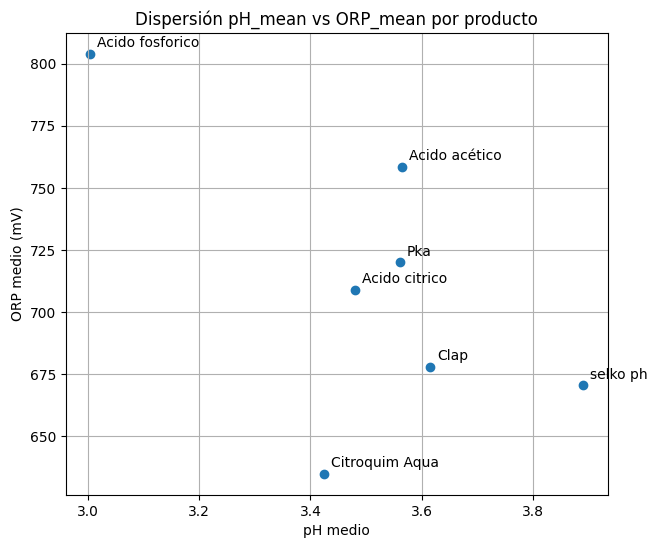

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(stab["pH_mean"], stab["ORP_mean"])
for label, x, y in zip(stab.index, stab["pH_mean"], stab["ORP_mean"]):
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(5, 5))

ax.set_xlabel("pH medio")
ax.set_ylabel("ORP medio (mV)")
ax.set_title("Dispersión pH_mean vs ORP_mean por producto")
plt.grid(True)
plt.show()

In [12]:
def plot_orp_vs_ph_means(
    stab_df: pd.DataFrame,
    palette: list[str] | None = PALETTE,
    save_html: str | Path | None = None,
    width: int = 500,
    height: int = 650,
):
    """
    Scatter Plotly pH_mean vs ORP_mean (un punto por producto) con zonas de ORP.

    Parameters
    ----------
    stab_df  : DataFrame con índice = producto y columnas 'pH_mean', 'ORP_mean'.
    palette  : lista de colores hex (uno por producto, rotan si faltan).
    save_html: ruta .html para exportar (opcional).
    width    : ancho de la figura (px).
    height   : alto  de la figura (px).

    Returns
    -------
    fig : plotly.graph_objects.Figure
    """
    # ------------------------------------------------------------------
    # 1) Prepara datos y colores
    # ------------------------------------------------------------------
    df_plot = (
        stab_df.reset_index()
               .rename(columns={'index': 'producto'})
               .assign(
                   dos=['0.1', '0.1', '0.1', '0.3', '1.6', '0.1', '0.7']
               )
    )
    df_plot["producto"] = (
        df_plot["producto"] + ' (dosis: ' + df_plot["dos"] + ')'
    )

    prods = df_plot["producto"].unique()
    color_map = {p: palette[i % len(palette)] for i, p in enumerate(prods)}

    # ------------------------------------------------------------------
    # 2) Dispersión básica
    # ------------------------------------------------------------------
    fig = px.scatter(
        df_plot,
        x="pH_mean",
        y="ORP_mean",
        text="producto",
        color="producto",
        color_discrete_map=color_map,
        title="Dispersión pH promedio vs ORP promedio por producto y dosis",
        width=width,
        height=height,
    )

    # Texto negro y marcador personalizado
    fig.update_traces(
        textposition="top center",
        textfont=dict(color="black"),
        marker=dict(size=12, line=dict(width=1, color="black"))
    )

    # ------------------------------------------------------------------
    # 3) Layout general
    # ------------------------------------------------------------------
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        paper_bgcolor="rgba(0,0,0,0)",
        legend_title="",
        legend_font_color="black",
        font=dict(color="black"),
        xaxis=dict(
            title="pH medio",
            linecolor="black", mirror=True, showline=True,
            gridcolor="rgba(0,0,0,0.1)",
            tickfont_color="black",
        ),
        yaxis=dict(
            title="ORP medio (mV)",
            linecolor="black", mirror=True, showline=True,
            gridcolor="rgba(0,0,0,0.1)", tickfont_color="black",
        ),
        title=dict(font=dict(color="black"), x=0.5),
    )

    # Marco exterior
    fig.add_shape(
        type="rect",
        xref="paper", yref="paper",
        x0=0, y0=0, x1=1, y1=1,
        line=dict(color="black", width=1)
    )

    # ------------------------------------------------------------------
    # 4) Zonas de ORP
    # ------------------------------------------------------------------
    ymax = df_plot["ORP_mean"].max() * 1.05
    ymin = df_plot["ORP_mean"].min() * 0.95

    zonas = [
        # (y0, y1, color_rgba, etiqueta, y_text)
        (740, ymax, "rgba(28,128,116,0.10)", "ÁCIDOS EN LÍQUIDO", 800),
        (700, 740, "rgba(245,173,104,0.10)", "ÁCIDOS EN POLVO",   720),
        (ymin, 700, "rgba(199,105,49,0.10)", "MEZCLA DE ÁCIDOS",  660),
    ]

    for y0, y1, rgba, label, y_text in zonas:
        fig.add_shape(
            type="rect",
            xref="paper", yref="y",
            x0=0, x1=1, y0=y0, y1=y1,
            fillcolor=rgba, line_width=0
        )
        fig.add_annotation(
            xref="paper", yref="y",
            x=0.4, y=y_text, showarrow=False,
            text=label, font=dict(color="black", size=12, family="Arial")
        )

    # ------------------------------------------------------------------
    # 5) Exportar (opcional) y devolver
    # ------------------------------------------------------------------
    if save_html:
        p = Path(save_html)
        p.parent.mkdir(exist_ok=True, parents=True)
        fig.write_html(p, include_plotlyjs="cdn")
        print(f"[INFO] Gráfica guardada en {p.resolve()}")

    return fig

In [13]:
fig_zonas_producto = plot_orp_vs_ph_means(stab, width= 1550,height= 650)
s3.save_plotly_html(fig_zonas_producto, f"zonas_producto.html")
fig_zonas_producto

In [24]:
fig_ph = plot_metric_curve(
    df_clean,
    metric="ph",
    #save_html=f"{ROOT_IMAGEN}/ph_curva.html"
)
s3.save_plotly_html(fig_ph, f"ph_curva.html")

fig_orp = plot_metric_curve(
    df_clean,
    metric="orp",
    #save_html=f"{ROOT_IMAGEN}/orp_curva.html"
)
s3.save_plotly_html(fig_orp, f"orp_curva.html")

fig_stab = plot_ph_stability_bar(
    stab,
    #save_html=f"{ROOT_IMAGEN}/ph_stability.html"
)
s3.save_plotly_html(fig_stab, f"ph_stability.html")

fig_rel = plot_orp_vs_ph(
    df_clean,                      # tu DataFrame con pH y ORP
    #save_html=f"{ROOT_IMAGEN}/orp_ph.html"
)
s3.save_plotly_html(fig_rel, f"orp_ph.html")

In [25]:
fig_ph

In [16]:
fig_stab

In [17]:
fig_orp

In [18]:
fig_rel

In [19]:

# ------------------------------------------------------------------
stab = (
    df.groupby("producto").agg(
        pH_sd=("ph", "std"),
        pH_range=("ph", lambda x: x.max() - x.min()),
        orp_sd=("orp", "std"),
        orp_range=("orp", lambda x: x.max() - x.min())
    ).round(2)
)

In [20]:
stab

,pH_sd,pH_range,orp_sd,orp_range
producto,,,,
Acido acético,0.94,2.89,71.19,228
Acido citrico,0.95,2.90,79.60,259
Acido fosforico,1.12,3.44,96.29,303
Citroquim Aqua,1.12,3.40,114.49,285
Clap,1.01,3.08,109.70,316
Pka,1.06,3.41,99.75,325
selko ph,0.91,2.78,111.42,309


In [21]:
# -------------------------------------------------
# 2) Filtrar: fuera lecturas iniciales con pH > 6
# -------------------------------------------------
df_filt = df[~((df["elapsed_h"] == 0) & (df["ph"] > 6))]

# -------------------------------------------------
# 3) Métricas de estabilidad (solo pH)
# -------------------------------------------------
stab_ph = (
    df_filt.groupby("producto").agg(
        pH_sd=("ph", "std"),
        pH_range=("ph", lambda x: x.max() - x.min()),
        pH_cv=("ph", lambda x: x.std()/x.mean()*100),
        n=("ph", "size")
    ).round(3)
)

# Ordenar del más estable (SD menor) al menos
stab_ph_sorted = stab_ph.sort_values("pH_sd")
stab_ph_sorted

,pH_sd,pH_range,pH_cv,n
producto,,,,
Citroquim Aqua,0.029,0.09,0.837,8
selko ph,0.031,0.10,0.788,8
Clap,0.035,0.11,0.953,8
Acido acético,0.047,0.15,1.327,8
Acido citrico,0.058,0.15,1.654,8
Acido fosforico,0.070,0.18,2.352,8
Pka,0.106,0.36,2.993,8


In [22]:

df_products = pd.DataFrame({
    "Producto": [
        "Citroquim Aqua", "selko ph", "Clap", "Pka",
        "Ácido cítrico", "Ácido fosfórico", "Ácido acético"
    ],
    "Tipo / Descripción": [
        "Mezcla de ácidos", "Mezcla de ácidos", "Mezcla de ácidos", "Ácidos en polvo",
        "Ácido orgánico en polvo", "Ácido inorgánico líquido", "Ácido orgánico líquido"
    ],
    "Concentración declarada": [
        "n/d", "n/d", "n/d", "n/d", "99.5 %", "85 %", "99.5 %"
    ],
    "Preparación (solución madre)": [
        "—", "—", "—", "30 g en 500 mL de agua", "30 g en 500 mL de agua", "—", "—"
    ],
})

# Save to CSV
csv_path = f"productos_acidificantes.csv"
s3.save_dataframe(df_products, csv_path)




In [23]:
df_products

,Producto,Tipo / Descripción,Concentración declarada,Preparación (solución madre)
0,Citroquim Aqua,Mezcla de ácidos,n/d,—
1,selko ph,Mezcla de ácidos,n/d,—
2,Clap,Mezcla de ácidos,n/d,—
3,Pka,Ácidos en polvo,n/d,30 g en 500 mL de agua
4,Ácido cítrico,Ácido orgánico en polvo,99.5 %,30 g en 500 mL de agua
5,Ácido fosfórico,Ácido inorgánico líquido,85 %,—
6,Ácido acético,Ácido orgánico líquido,99.5 %,—
